In [1]:
# http://yann.lecun.com/exdb/mnist/    ### Dataset Download
# pip install python-mnist==0.5        ### mnist library

In [4]:
#!pip install python-mnist==0.5  

  Created wheel for python-mnist: filename=python_mnist-0.5-py3-none-any.whl size=11095 sha256=b68410d78b4da21a8f65fbabbba321788a0ddc96b9507f0bcc9086c3bfc64443
  Stored in directory: /Users/sanghyuk/Library/Caches/pip/wheels/fc/2a/46/393fb56077504245eb9bc04558f478d6916d5e2dc50e8967f3
Successfully built python-mnist


# Training

유명한 손글씨 데이터인 MNIST 를 이용해서, 다양한 방식으로 딥러닝 모델을 학습해보도록 하자

- Optimization 방법을 이용하여 training 속도를 높여준다.
- 기존에 배운 Ridge model 이 아닌, 새롭게 배우는 overfitting 방지법인 Dropout 의 개념을 이해하고 코드로 구현한다.
- Training 하는 동안 layer 들을 하나하나 정규화 시켜주는 batch normalization 을 실습해 보도록한다.

### Import Library

In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

In [5]:
from mnist import MNIST

import matplotlib.pyplot as plt
import random

Check GPU and fix the random seed

In [8]:
# GPU가 있으면 이게 True
torch.cuda.is_available()

False

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


### 2. Import dataset

In [12]:
mnist = MNIST('./data/MNIST/raw/')
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

In [13]:
# raw data 의 형태를 확인
print(len(x_test))
x_test[:3]

10000


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [16]:
type(x_test)

list

### 3. Data Preprocessing

In [17]:
# data 는 list 형식을 되어 있으므로 shape 을 보고, 이미지 visualization 을 하기 편한 array 형태로 바꾸어준다.

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)  

x_test = np.asarray(x_test)
y_test = np.asarray(y_test) 

In [18]:
 x_test.shape # 28*28 = 784

(10000, 784)

### Explore data

In [19]:
len(x_train)

60000

In [20]:
len(x_test)

10000

In [21]:
x_train.shape

(60000, 784)

### Data visualization

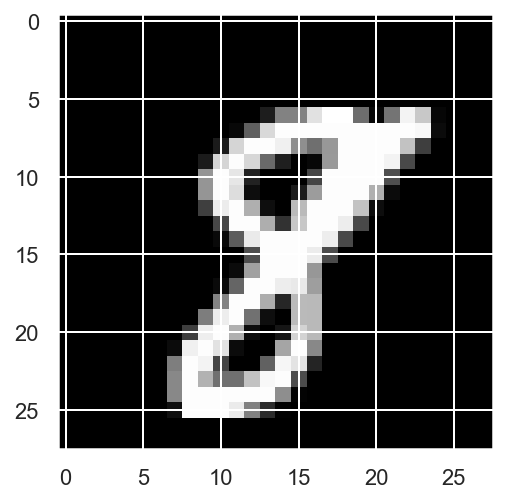

number 5


In [24]:
plt.imshow((np.array(x_train[55]).reshape(28,28)), cmap='gray')
plt.show()
print("number", y_train[1245])

### MNIST dataset 을 dataloader 를 이용해서 실제 변수에 담기

In [33]:
batch_size = 1000
# x와 y를 묶어주는 것. 
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
trainloader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [37]:
for i in train_data:
    print(i)
    break

(tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  

In [28]:
train_data

In [29]:
len(train_data)

60000

In [32]:
train_data

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

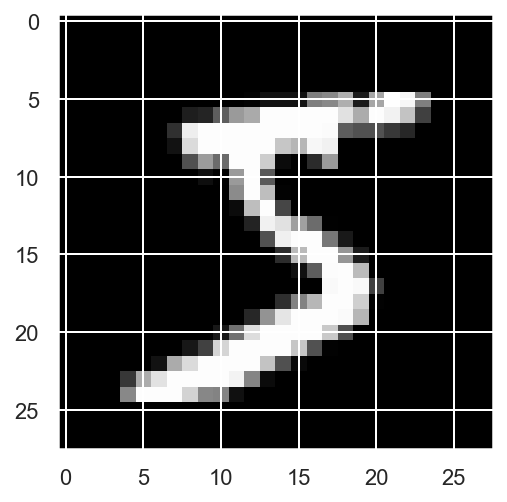

tensor(5.)


In [34]:
for X, y in train_data:
    print(X)
    plt.imshow(X.reshape(28,28), cmap='gray')
    plt.show()
    print(y)
    break

##### Dataloader 함수를 자세히 뜯어보자

dataloader 에는 배치사이즈만큼 묶여서 x_data와 y_data 가 pair 로 묶여있다.

In [35]:
length = len(trainloader)
print("{}개의 image 가 batch size {}개로 묶여서 총 {} 개의 batch 묶음이 생겼다".format(len(x_train),batch_size, length))

60000개의 image 가 batch size 1000개로 묶여서 총 60 개의 batch 묶음이 생겼다


0 tensor(4.)
torch.Size([1000, 784]) torch.Size([1000])


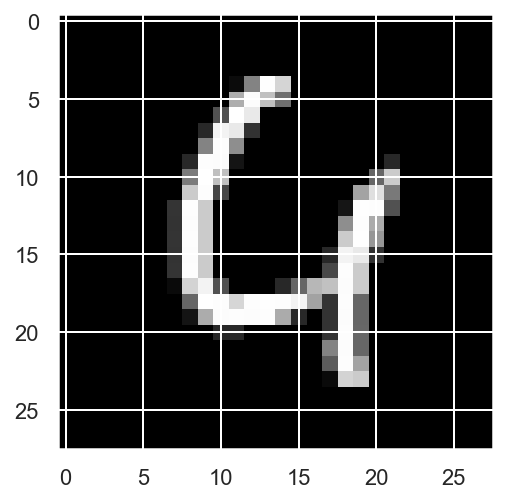

In [40]:
for batch_idx,(x_data, y_data) in enumerate(trainloader):
    plt.imshow(x_data[0].numpy().reshape(28,28), cmap = 'gray')
    print(batch_idx, y_data[0])
    print(x_data.shape, y_data.shape)
    break

### Build Model USING Sequential Method

In [41]:
# 뉴럴 layer 설정
linear1 = torch.nn.Linear(784,256)
linear2 = torch.nn.Linear(256,64)
linear3 = torch.nn.Linear(64,10) # y class 0~9 => 10

relu = torch.nn.ReLU()

In [42]:
# Sequential 을 이용해 model 설정
# 위의 뉴럴 layer 들을 가지고 온다
model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3)

In [45]:
# gpu쓰는 경우는, 아래 to(device) 해주면, 우리가 계산할것들이 다 gpu에 올라간다. 
#model = model.to(device)
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

### Set parameters

In [46]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

Cross Entropy 의 중요한 점은<br>
"The losses are averaged across observations for each minibatch."<br>
즉 미니배치들의 ` 평균 값` 을 구해준다는 것이다. <br><br>
ex) mini batch size 가 32면 32개 image data 의 loss 값의 평균을 구해준다<br>
이는 나중에 epoch 마다 loss 값을 구할 때 꼭 고려되어야 하는 부분이다.<br>
(= 모든 이미지 갯수만큼이 아닌, ` mini batch 의 갯수` 만큼 나누어준다)

즉, Cross Entropy는 미니배치로 할때는, 각 미니배치들의 평균을 구해준다는 것. Cross Entropy라는것, PyTorch에서 

In [48]:
# CrossEntropyLoss 내에 Softmax function 이 포함되어 있으므로 따로 설정해줄 필요 없다
loss_function = torch.nn.CrossEntropyLoss()

# 먼저 optimizer 는 SGD 로 설정
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

### Model train (SGD)
- 1. Optimizer 는 SGD 방법을 사용
- 2. X input 을 받는 model 은 y_predict 변수에 넣어준다
- 3. 정의한 loss function 을 이용해서 loss 를 구한 후
- 4. back propagation 으로 gradient 를 구해간다
- 5. optimizer_SGD.step() 으로 weight 를 update 한다

### Model train (SGD)
- 1. for 문에 epoch 를 담아주고
- 2. 그 안에 또다시 for 문을 하나 더 담아서 mini batch 를 하나씩 돌린다
- 3. mini batch 마다 image 와 label 을 하나씩 불러와서 to(device) 를 써서 GPU 메모리 위에 올려놓은 후
- 4. optimizer.zero_grad 로 weight 를 초기화 한후
- 5. model 에 image 를 넣어서 prediction 값을 뽑아낸 후
- 6. 미리 정의해둔 loss function 으로loss 값을 얻어낸다.
- 7. loss.backward 를 사용하여 
- 8. optimizer.step() 을 이용해 weight 값을 update 한 후 for 문이 다 돌때까지 기다림

In [50]:
len(trainloader)
x_data.shape

torch.Size([1000, 784])

In [63]:
print(y_predict.shape, y_label_long.shape)

torch.Size([1000, 10]) torch.Size([1000])


In [51]:
# Model Train(SGD)

loss_list = []

for epoch_num in range(epoch):
    average_cost = 0
      
    for batch_idx, (x_data, y_label) in enumerate(trainloader):
        num_of_mini_batch =  len(trainloader) # 60
        # trainloader loader 의 length는 아까 보았듯이 총 60개 (batch_size = 1000 이고 총 data 는 60000개 이므로)
        # epoch 하나당 평균 loss 를 구해주어야 할 때 꼭 필요하다
            
        # train 시킬 image data
        input_image = x_data.to(device)
        label = y_label.to(device)
                
        # Gradient 초기화
        optimizer.zero_grad()
        
        # Model 에 train data 를 넣고 predict 값 산출
        y_predict = model(input_image)
        
        # Loss fucntion 에 넣어서 계산하기 위해 y data의 type 을 바꿔준다
        y_label_long = torch.tensor(label, dtype=torch.long)
        y_label_long = y_label_long.to(device)
        
        # Softmax 와 Cross Entropy 를 한 꺼번에 구현
        # 배치 한 묶음안에 있는 image 의 평균 loss 값이 저장
        loss = loss_function(y_predict, y_label_long)
        if batch_idx % 10 == 0:
            print("loss value %.5f" %(loss.item()))
        
        # Back Propagation
        loss.backward()
        
        # Optimizer 를 한 step 내딛는다 -> w 의 값을 갱신
        optimizer.step()
             
        # epoch 마다 평균 loss 를 구하기 위해 average loss 값을 update
        # loss.item() 명령어를 내려서 연산이 가능하게끔 바꾸어준다
        # print(type(loss)) => 'torch.Tensor'
        # print(type(loss.item())) => 'float'
        average_cost = average_cost + (loss.item()/num_of_mini_batch) # +=
        
        # 각 batch 한 묶음에 관한 loss 값 저장 (후에 plot 을 그릴 예정)
        # loss 는 mini batch 하나의 평균 loss 가 들어가있다
        loss_list.append(loss)
        
    # epoch 마다 평균 loss 값을 print
    print("epoch {} 의 평균 loss 값은 ==> {:.5f}".format((epoch_num+1), average_cost))

<ipython-input-51-2dd23cbeba1f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_label_long = torch.tensor(label, dtype=torch.long)


loss value 14.56505
loss value 11.60819
loss value 2.06083
loss value 1.87345
loss value 1.59717
loss value 1.61444
epoch 1 의 평균 loss 값은 ==> 20.13342
loss value 1.38397
loss value 1.39387
loss value 1.29693
loss value 1.24761
loss value 1.18842
loss value 1.06117
epoch 2 의 평균 loss 값은 ==> 1.23438
loss value 0.91355
loss value 0.94864
loss value 0.88170
loss value 0.59931
loss value 0.66761
loss value 0.54713
epoch 3 의 평균 loss 값은 ==> 0.74862
loss value 0.58868
loss value 0.51271
loss value 0.57319
loss value 0.63869
loss value 0.39661
loss value 0.67300
epoch 4 의 평균 loss 값은 ==> 0.52065
loss value 0.46524
loss value 0.44276
loss value 0.42619
loss value 0.39335
loss value 0.34236
loss value 0.39269
epoch 5 의 평균 loss 값은 ==> 0.39412
loss value 0.36766
loss value 0.50838
loss value 0.42617
loss value 0.33211
loss value 0.29017
loss value 0.32525
epoch 6 의 평균 loss 값은 ==> 0.36131
loss value 0.32260
loss value 0.28294
loss value 0.31647
loss value 0.31070
loss value 0.34688
loss value 0.28390
e

### Epoch 1 (첫번째 epoch) 의 loss 값을 계산

In [64]:
# epoch 하나당 60개의 batch 묶음
epoch_loss = 0
for i in range(60):
    epoch_loss = epoch_loss + loss_list[i]
    
print(epoch_loss/60)

tensor(20.1334, grad_fn=<DivBackward0>)


### Check Loss value and plotting

In [65]:
# 60000개를 1000 배치로 나누었을때 60이 되므로 epoch 하나당 60 묶음의 배치가 학습이된다
# 15 epoch 이므로 900 묶음의 배치가 학습이 되게 되고 list 에 append 되는 loss value 도 900 개가 된다.
print("loss_list의 길이 =",len(loss_list))

loss_list의 길이 = 900


In [66]:
loss_list[:10]

[tensor(14.5651, grad_fn=<NllLossBackward0>),
 tensor(73.5663, grad_fn=<NllLossBackward0>),
 tensor(323.1079, grad_fn=<NllLossBackward0>),
 tensor(148.2604, grad_fn=<NllLossBackward0>),
 tensor(66.6861, grad_fn=<NllLossBackward0>),
 tensor(283.4831, grad_fn=<NllLossBackward0>),
 tensor(13.6886, grad_fn=<NllLossBackward0>),
 tensor(35.8386, grad_fn=<NllLossBackward0>),
 tensor(9.0690, grad_fn=<NllLossBackward0>),
 tensor(129.6212, grad_fn=<NllLossBackward0>)]

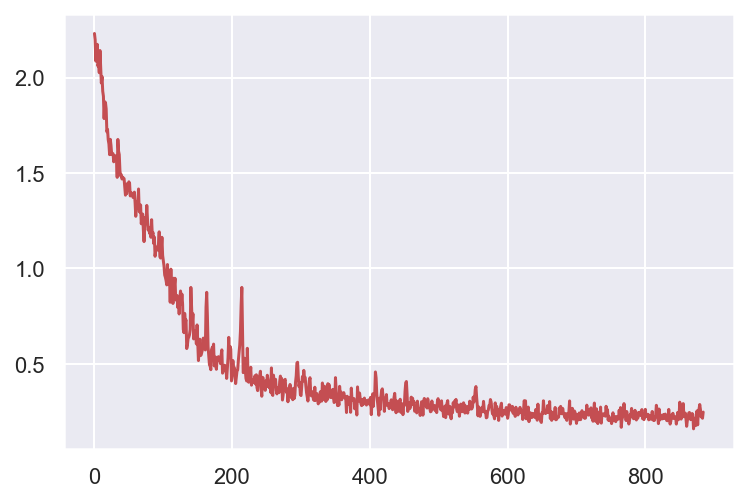

In [69]:
# 처음부터 그리면 초반 5개 정도는 loss 값이 급격하게 낮아지므로 변화량을 제대로 확인하기가 어렵다.
plt.plot(np.array(loss_list[15:]), 'r')

### Loss list의 값을 저장

In [70]:
loss_list

[tensor(14.5651, grad_fn=<NllLossBackward0>),
 tensor(73.5663, grad_fn=<NllLossBackward0>),
 tensor(323.1079, grad_fn=<NllLossBackward0>),
 tensor(148.2604, grad_fn=<NllLossBackward0>),
 tensor(66.6861, grad_fn=<NllLossBackward0>),
 tensor(283.4831, grad_fn=<NllLossBackward0>),
 tensor(13.6886, grad_fn=<NllLossBackward0>),
 tensor(35.8386, grad_fn=<NllLossBackward0>),
 tensor(9.0690, grad_fn=<NllLossBackward0>),
 tensor(129.6212, grad_fn=<NllLossBackward0>),
 tensor(11.6082, grad_fn=<NllLossBackward0>),
 tensor(9.6957, grad_fn=<NllLossBackward0>),
 tensor(4.8658, grad_fn=<NllLossBackward0>),
 tensor(2.7146, grad_fn=<NllLossBackward0>),
 tensor(2.3035, grad_fn=<NllLossBackward0>),
 tensor(2.2313, grad_fn=<NllLossBackward0>),
 tensor(2.1982, grad_fn=<NllLossBackward0>),
 tensor(2.0863, grad_fn=<NllLossBackward0>),
 tensor(2.1427, grad_fn=<NllLossBackward0>),
 tensor(2.1746, grad_fn=<NllLossBackward0>),
 tensor(2.0608, grad_fn=<NllLossBackward0>),
 tensor(2.0758, grad_fn=<NllLossBackward0

In [72]:
# plot 비교를 위해 pickle 형태로 저장
import pickle

# wb - 바이트 형식으로 저장

with open('./pickle/SGD.pickle', 'wb') as f:
    pickle.dump(loss_list, f)

### Test and check the accuracy

In [79]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size = 5000, shuffle=False)

In [80]:
predicted

tensor([3, 9, 9,  ..., 4, 5, 6])

In [81]:
# test data 는 gradient 를 계산할 필요가 없다
with torch.no_grad():
    num_total_data = 0
    correct = 0 # 맞는 것의 갯수를 count
    for batch_idx, (images, labels) in enumerate(testloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs_softmax = torch.nn.functional.softmax(outputs)
        
        # softmax 를 이용해 probability 가 가장 큰 index 를 가져옴
        predicted = torch.argmax(outputs_softmax, dim=1)
        
        # len(images) 는 결국 배치 size 를 나타내는 것이므로 batch size 를 계속 더해주면 data 의 총 길이가 된다.
        num_total_data += len(images)
        
        # 맞게 예측한 것만 세어야하는데 이때 쓸 수 있는 좋은 방법은 (True is equal to 1) 를 이용하는 것이다.
        # itme() 을 해주면 tensor type 을 벗어던지고 단순한 float 형으로 다시 태어날 수 있다.
        answer = sum(labels==predicted).item()
        correct += answer
        
print("SGD 를 이용한 모델의 정확도는 {:.5f}%".format((correct/num_total_data)*100))

SGD 를 이용한 모델의 정확도는 93.37000%


<ipython-input-81-0cf5d531535b>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_softmax = torch.nn.functional.softmax(outputs)


### Check the accuracy using Original Image & Predicted Label

예측한 숫자는 3이다


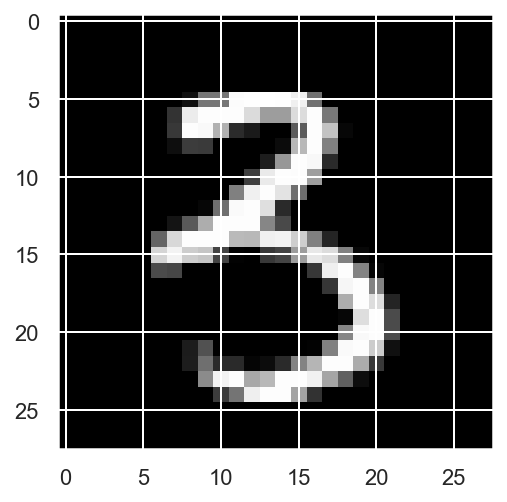

In [84]:
print("예측한 숫자는 {}이다".format(predicted[0]))
plt.imshow(images[0].cpu().reshape(28,28), cmap = 'gray')

## Bonus

### ☆ One-hot Encoding

one hot Encoding 을 구현하기 위해 random 한 난수를 생성

In [93]:
nb_classes = 10

idx = np.random.permutation(nb_classes)
ex_list = [x for x in idx]

In [94]:
ex_list

[1, 0, 6, 4, 2, 8, 9, 5, 7, 3]

In [95]:
# np.eye 는 diagonal entry 가 1 인 행렬을 가리킨다
# ex_list 에는 숫자가 있으므로 각 숫자에 맞는 row 를 가져오게 된다 (index 에 맞는 대각 1짜리 행렬이 있으므로)
one_hot_targets = np.eye(nb_classes)[ex_list]
y_train_onehot = one_hot_targets

In [96]:
y_train_onehot

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [97]:
ex_list

[1, 0, 6, 4, 2, 8, 9, 5, 7, 3]

In [98]:
np.eye(nb_classes)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])